Exo 

In [1]:
# Modules
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic 

In [2]:
# Connecting to my drive
from __future__ import print_function
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/ticatrip_exo/"

Mounted at /content/drive
data


On commence par lire les fichiers.

In [4]:
data_path = "/content/drive/My Drive/ticatrip_exo/data/"

# Reading csv files
ticket_array = pd.read_csv(os.path.join(data_path, "ticket_data.csv"))
stations_array = pd.read_csv(os.path.join(data_path, "stations.csv"))
providers_array =  pd.read_csv(os.path.join(data_path, "providers.csv"))
cities_array =  pd.read_csv(os.path.join(data_path, "cities.csv"))


In [3]:
#Useful function
def str_time_to_obj_datetime(string_date):
  """Take a string date of format YYYY-MM-DD H:M:S+00 and convert it to python
  datetime object

  Args:
  string string_date : a date in the mentionned str format

  Return:
  datetime datetime_obj : a datetime object representing the input string date
  """

  datetime_obj = datetime.strptime(string_date, '%Y-%m-%d %H:%M:%S+00')
  return datetime_obj



On calcule les premières stats.

In [7]:
# Basic stat values

# Regarding prices
price_column = ticket_array['price_in_cents']
min_price = min(price_column)
max_price = max(price_column)
mean_price = np.mean(price_column)
var_price = np.var(price_column)

# Regarding trip time
# Converting to datetime in a probably non-efficient way :)
travel_time = []
departure_date_list = []
for i in range(len(ticket_array['departure_ts'])):
  departure_time = str_time_to_obj_datetime(ticket_array['departure_ts'][i])
  arrival_time = str_time_to_obj_datetime(ticket_array['arrival_ts'][i])

  # Compute travel time
  travel_time.append((arrival_time - departure_time).total_seconds())

  # storing departure_date_list for further process below
  departure_date_list.append(departure_time)
  
# Convert to array and compute stat 
travel_time = np.array(travel_time)

min_time = min(travel_time)
max_time = max(travel_time)
mean_time = np.mean(travel_time)
var_time = np.var(travel_time)

print("The minimum price of the dataset is :", min_price, "in cents")
print("The maximum price of the dataset is :", max_price, "in cents")
print("The mean price of the dataset is :", mean_price, "in cents")
print("The variance price of the dataset is :", var_price, "in cents")
print('----------------------------------------------------------')
print("The minimum time of the dataset is :", min_time, "in seconds")
print("The maximum time of the dataset is :", max_time, "in seconds")
print("The mean time of the dataset is :", mean_time, "in seconds")
print("The variance time of the dataset is :", var_time, "in seconds")

The minimum price of the dataset is : 300 in cents
The maximum price of the dataset is : 38550 in cents
The mean price of the dataset is : 4382.711061374178 in cents
The variance price of the dataset is : 13982365.672689147 in cents
----------------------------------------------------------
The minimum time of the dataset is : 1200.0 in seconds
The maximum time of the dataset is : 1774260.0 in seconds
The mean time of the dataset is : 25477.247600043145 in seconds
The variance time of the dataset is : 1274392946.9653363 in seconds


Une première courbe prix en fonction du temps de trajet. Elle ne montre pas grand-chose puisqu’un trajet plus court en temps pour la même distance est probablement moins cher, cependant un trajet long indique potentiellement un trajet plus lointain et donc peut être plus cher. De plus certaines destinations sont certainement plus chères que d'autre, la date de trajet ou le jour de la semaine influant aussi.

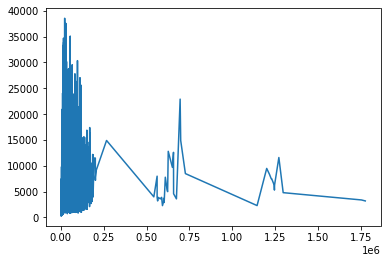

In [9]:
# Price versus time plot

# Sort indexes by travel time
sorted_travel_time_indexes = np.argsort(travel_time)

# Apply indexes to travel time array and same to their associated prices
sorted_travel_time = travel_time[sorted_travel_time_indexes]
associated_prices_sorted = price_column[sorted_travel_time_indexes]

#Plot results
plt.plot(sorted_travel_time, associated_prices_sorted)

En prenant pour hypothèse que la base contient suffisamment de tickets répartis dans une année, on peut estimer la variation du prix en fonction de la période de l'année.

Après un coup d'œil aux données je me rend compte qu'elles sont quasi toutes en octobre 2017 alors on oublie l'idée..


In [10]:
# Dictionary of {month, list of prices} values
dico = {}

# Parsing departure_date_list
for i in range(len(departure_date_list)):
  month = departure_date_list[i].month
  price = price_column[i]

  # This part handles the creation of a new key and list and/or adding element to dict
  try:
    price_by_month_list = dico[month]
    price_by_month_list.append(price)
    dico[month] = price_by_month_list

  except: # this fail for a key error then we create the key 
    price_by_month_list = []
    price_by_month_list.append(price)
    dico[month] = price_by_month_list

# Compute average price on each months
mean_price_by_month = []
for month in range(1,13):
  # This line fails on key error because some months are not represented that's 
  # why i checked  the table and realize it is mostly on october 2017
  mean_price_by_month.append( np.mean(dico[month]))

plt.plot(mean_price_by_month)

KeyError: ignored

On peut faire pareil pour les jours d'octobre, on reste indifférent de l'année même si à priori toute la table est en 2017.
On observe une augmentation des prix tout au long du mois.
Le jour le moins cher est souvent le lundi, alors que mardi et jeudi sont souvent les jours les plus chers.

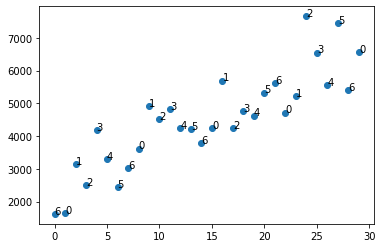

In [11]:
# Same code for days
dico = {}

# Adding a week day dict to see if prices evolve with weekday
weekday_dict = {}

for i in range(len(departure_date_list)):

  # on ne considere que les données du mois d'octobre 
  if departure_date_list[i].month == 10:
    
    day = departure_date_list[i].day
    weekday_dict[day] = departure_date_list[i].weekday()
    price = price_column[i]

    try:
      price_by_day_list = dico[day]
      price_by_day_list.append(price)
      dico[day] = price_by_day_list

    except:
      price_by_day_list = []
      price_by_day_list.append(price)
      dico[day] = price_by_day_list

mean_price_by_day = []
weekday_list = []

# For each day of the month
for day in range(1,31):
    # We add this try except in case some days are not represented and to avoid a 
    # key eror, we fill them with a price of 0
    try:
      mean_price_by_day.append( np.mean(dico[day]))
      weekday_list.append(weekday_dict[day])
    except:
      dico[day]= 0
      mean_price_by_day.append( np.mean(dico[day]))

# Plotting result

# Day of month vector
x = list(range(30))

# Scatter plot
fig, ax = plt.subplots()
ax.scatter(x, mean_price_by_day)

# Week day annotation 0--> Monday...6-->Sunday
for i, txt in enumerate(weekday_list): 
    ax.annotate(txt, (x[i], mean_price_by_day[i]))


Pour chaque ticket on va relever le prix, le moyen de transport, le temps et la distance géodésique (geopy) afin d'extraire des valeurs dans les scripts suivants.
Ce script suppose que pour un ticket un seul moyen de transport est utilisé ce que je n'ai pas vérifié


In [51]:
# Parse ticket table and compute geodesic distance, saves results in a list
# saves also prices and transport type for each ticket

# to be launched once and process resuts elsewhere cause geodesic distance 
# computation takes a bit of time

price_list = []
transport_type_list = []
geo_dist_list = []

for i in range(len(ticket_array)):

  # Get transport type
  company_id = ticket_array['company'][i]

  # Pas tres bien compris ici company_id(ticket_data) semble matcher id 
  # dans providers et non company id 
  transport_type = str(providers_array[providers_array['id']==company_id]['transport_type'].values)
  transport_type_list.append(transport_type)
  
  # Get price
  price = ticket_array['price_in_cents'][i]
  price_list.append(price)

  # For each ticket compute roughly distance (geodesic not road for buses or rail for train)
  # in this case it does not matter cause the goal is to join two cities by any means
  
  # Get city id
  o_city_id = ticket_array['o_city'][i]
  d_city_id = ticket_array['d_city'][i]

  # Get lat / long
  o_lat=float(cities_array[cities_array['id']==o_city_id]['latitude'])
  o_longi=float(cities_array[cities_array['id']==o_city_id]['longitude'])

  d_lat=float(cities_array[cities_array['id']==d_city_id]['latitude'])
  d_longi=float(cities_array[cities_array['id']==d_city_id]['longitude'])

  # Convert to tuples
  o_city_pos = (o_lat, o_longi)
  d_city_pos = (d_lat, d_longi)

  # Distance calculated in km 
  geo_dist = geodesic(o_city_pos, d_city_pos).km
  geo_dist_list.append(geo_dist)

Figure suivante : prix en fonction de la distance encore une fois peu interprétable, le prix dépendant d'autres facteurs

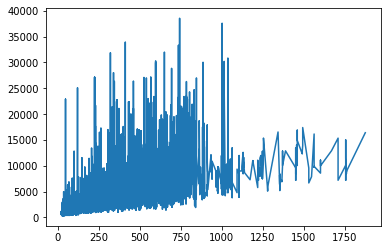

In [ ]:
# Price versus distance plot

# Cast to array
geo_dist_list = np.array(geo_dist_list)
price_list = np.array(price_list)

# Sort indexes by distance
sorted_travel_dist_indexes = np.argsort(geo_dist_list)

# Apply indexes to travel distance  and same to their associated prices
sorted_travel_dist = geo_dist_list[sorted_travel_dist_indexes]
associated_prices_sorted = price_list[sorted_travel_dist_indexes]

# Plot results
plt.plot(sorted_travel_dist, associated_prices_sorted)

On classe les trajets par moyen de transport 

Mean price by bus is : 3652.4480359472386
Mean price by train is : 8506.634793174495
Mean price by carpooling is : 2742.171907048575


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


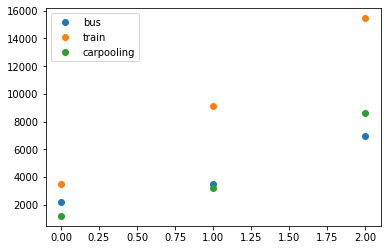

In [78]:
# Class tickets prices/distance/times in different lists depending on transport
# types 

# Creating list of prices dist and distances for each types
bus_prices = []; bus_times = []; bus_dist = []
car_prices = []; car_times = []; car_dist = []
train_prices = []; train_times = []; train_dist = []
carpooling_prices = []; carpooling_times = []; carpooling_dist = []

# Parsing the transport types
for i in range(len(transport_type_list)):

  # Depending on the type we add prices time and dist to different lists
  if transport_type_list[i]=="['bus']":
    bus_prices.append(price_list[i])
    bus_times.append(travel_time[i])
    bus_dist.append(geo_dist_list[i])
  if transport_type_list[i]=="['car']":
    car_prices.append(price_list[i])
    car_times.append(travel_time[i])
    car_dist.append(geo_dist_list[i])
  if transport_type_list[i]=="['train']":
    train_prices.append(price_list[i])
    train_times.append(travel_time[i])
    train_dist.append(geo_dist_list[i])
  if transport_type_list[i]=="['carpooling']":
    carpooling_prices.append(price_list[i])
    carpooling_times.append(travel_time[i])
    carpooling_dist.append(geo_dist_list[i])

# Convert to arrays
bus_prices = np.array(bus_prices)
bus_times = np.array(bus_times)
bus_dist = np.array(bus_dist)
car_prices = np.array(car_prices)
car_times = np.array(car_times)
car_dist = np.array(car_dist)
train_prices = np.array(train_prices)
train_times = np.array(train_times)
train_dist = np.array(train_dist)
carpooling_prices = np.array(carpooling_prices)
carpooling_times = np.array(carpooling_times)
carpooling_dist = np.array(carpooling_dist)

# Compute mean of prices by type
print('Mean price by bus is :', np.mean(bus_prices))
#print('Mean price by car is :', np.mean(car_prices)) # no car ticket in database
print('Mean price by train is :', np.mean(train_prices))
print('Mean price by carpooling is :', np.mean(carpooling_prices))
print('-----------------------------------------------------------')
# Price by distance and transport type


# We will use a double for loop to iterate over each transport type and 
# each value in it (price/dist)
j=0
price_by_type_distance = []
price_by_type_lists = [bus_prices, train_prices, carpooling_prices]
for transport in [bus_dist, train_dist, carpooling_dist]:
  prices_by_distance_classes = []
  prices1 = []
  prices2 = []
  prices3 = []
  prices4 = []
  price_transport = price_by_type_lists[j]

  # depending on the distance (4 classes) we class the prices for each type
  for i in range(len(transport)):
    if transport[i]<=200:
      prices1.append(price_transport[i])
    if transport[i]>200 and transport[i]<=800:
      prices2.append(price_transport[i])
    if transport[i]>800 and transport[i]<=2000:
      prices3.append(price_transport[i])
    if transport[i]>2000:
      prices4.append(price_transport[i])

  # Convet to arrays
  prices1 = np.array(prices1)
  prices2 = np.array(prices2)
  prices3 = np.array(prices3)
  prices4 = np.array(prices4)

  # Mean prices of each class
  prices_by_distance_classes.append(np.mean(prices1))
  prices_by_distance_classes.append(np.mean(prices2))
  prices_by_distance_classes.append(np.mean(prices3))
  prices_by_distance_classes.append(np.mean(prices4))

  # Storing mean prices for each class and for each transport type
  price_by_type_distance.append(prices_by_distance_classes)
  j=j+1

# Convert to array
price_by_type_distance = np.array(price_by_type_distance)

# Plot results
plt.plot( price_by_type_distance[0],'o',  label="bus")
plt.plot( price_by_type_distance[1],'o', label="train")
plt.plot( price_by_type_distance[2],'o', label="carpooling")
plt.legend()

Chaque ensemble de point représente une classe (0,200)  (200,800) (800,2000)
aucune données pour + de 2000 km.
Le covoit est le moins cher pour les classes 1 et 2.
Le bus est le moins cher pour la classe 3.
Le train est toujours plus cher.